In [1]:
import os
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy import stats
from tqdm import tqdm
from ezephys import pltools

from lib.data import conditions as cond
from lib.data import tables as tab
from lib.features import decomposition as de
from lib.features import correlation as corr

In [2]:
np.random.seed(42)
plt.rc('svg', fonttype='none')

# Load data

In [3]:
engine = tab.sa.create_engine(os.environ['SQLALCHEMY_ENGINE_URL'])
Session = tab.sa.orm.sessionmaker(bind=engine)
session = Session()

Get the IDs of all cells that were added to the dataset on the first day.

In [4]:
day_one_cells = (
    session.query(tab.Cell)
    .join(tab.Cell.traces, tab.Trial)
    .filter(tab.Trial.day == 1)
    .subquery()
)

Get the average traces for non-catch trials of `day_one_cells` on days 1 and 7.

In [5]:
average_traces = []
days = []
cell_types = []
cell_ids = []
mouse_ids = []

for res in tqdm(
    session.query(tab.TrialAverageTrace, tab.Mouse)
        .join(day_one_cells, tab.TrialAverageTrace.cell_id==day_one_cells.c.id)
        .join(tab.Mouse, day_one_cells.c.mouse_id==tab.Mouse.id)
        .filter(
            tab.TrialAverageTrace.day.in_([1, 7]), 
            tab.TrialAverageTrace.trial_kind == 'non_catch',
            tab.Mouse.id != 'CL199',  # Excluded b/c fluorescence drift
        )
        .all()
):
    if not all(np.isnan(res[0].trace)):
        average_traces.append(res[0].trace)
        days.append(res[0].day)
        cell_ids.append(res[0].cell_id)
        cell_types.append(res[1].cell_type)
        mouse_ids.append(res[1].id)

100%|██████████| 4242/4242 [00:00<00:00, 143884.95it/s]


In [6]:
average_traces = np.array([tr[:390] for tr in average_traces])
days = np.array(days)
cell_types = np.array(cell_types)
cell_ids = np.array(cell_ids)

In [7]:
average_traces.shape

(4229, 390)

In [8]:
days

array([1, 7, 1, ..., 7, 1, 7])

In [9]:
cell_types

array([CellType.vip, CellType.vip, CellType.vip, ..., CellType.pv,
       CellType.pv, CellType.pv], dtype=object)

In [10]:
np.sum((days == 1) & (cell_types == cond.CellType.vip))

407

The data I imported has 407 VIP cells on day 1. If I did everything right, that should match your analysis.

# Helper function for saving figures

In [11]:
def savefig(fig_basename, **kwargs):
    for extension in ['png', 'svg', 'eps', 'pdf']:
        print(f'Saving {extension}')
        plt.savefig('.'.join([fig_basename, extension]), **kwargs)

**Trial components**

Durations are in seconds.

In [12]:
trial_structure = de.TrialBasisFunctions(
    390, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5
)

Trial structure is represented in terms of a set of rectangular functions. Here's one of them.

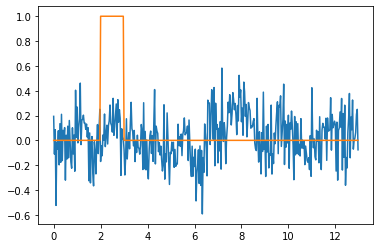

In [13]:
plt.plot(trial_structure.time, average_traces[10, :])
plt.plot(trial_structure.time, trial_structure.tone)

In [14]:
spearman_corr = {
    'tone': corr.vectorized_spearman_corr(average_traces, trial_structure.tone),
    'tone + delay': corr.vectorized_spearman_corr(average_traces, trial_structure.tone + trial_structure.delay),
    'reward': corr.vectorized_spearman_corr(average_traces, trial_structure.reward),
}

mean_fluorescence = {
    lab: average_traces[:, trial_component].sum(axis=1) / trial_component.sum()
    for lab, trial_component in {
        'tone fluo': trial_structure.tone, 
        'tone + delay fluo': trial_structure.tone + trial_structure.delay,
        'reward fluo': trial_structure.reward
    }.items()
}

In [15]:
mean_fluo_df = pd.DataFrame(
    {
        'day': days,
        'cell_type': cell_types,
        'cell_id': cell_ids,
        'mouse_id': mouse_ids,
        **mean_fluorescence,
        **spearman_corr
    }
)
mean_fluo_df

,day,cell_type,cell_id,mouse_id,tone fluo,tone + delay fluo,reward fluo,tone,tone + delay,reward
0,1,vip,3121,CL136,0.006833,-0.006349,-0.015298,-0.042650,-0.089601,-0.110405
1,7,vip,3121,CL136,0.056056,0.292485,0.064681,-0.205642,-0.022913,-0.320235
2,1,vip,3122,CL136,0.078297,0.026572,-0.122830,0.110171,0.048225,-0.311567
3,7,vip,3122,CL136,-0.027618,-0.061786,0.218031,-0.240343,-0.429629,-0.054292
4,1,vip,3123,CL136,-0.002098,0.013350,0.032032,-0.062735,-0.045220,-0.022335
...,...,...,...,...,...,...,...,...,...,...
4224,7,pv,2644,CL198,-0.107898,-0.029546,0.055185,-0.157180,-0.062845,0.159005
4225,1,pv,2645,CL198,-0.010278,0.062069,0.016830,-0.063077,0.110058,-0.012685
4226,7,pv,2645,CL198,-0.155872,-0.061751,0.062192,-0.254787,-0.206854,0.091508
4227,1,pv,2646,CL198,-0.015687,0.043476,0.038258,-0.070769,0.044699,0.033546


In [16]:
mean_fluo_df.describe()

,day,cell_id,tone fluo,tone + delay fluo,reward fluo,tone,tone + delay,reward
count,4229.000000,4229.000000,4229.000000,4229.000000,4229.000000,4229.000000,4229.000000,4229.000000
mean,3.999291,1794.551667,-0.018151,0.016969,0.052375,-0.037501,-0.011253,-0.007231
std,3.000355,1026.516748,0.161505,0.199496,0.319570,0.191799,0.220377,0.239922
min,1.000000,1.000000,-0.871482,-1.354365,-1.732902,-0.460685,-0.672803,-0.676155
25%,1.000000,1006.000000,-0.107622,-0.057383,-0.069471,-0.166496,-0.141033,-0.151666
50%,1.000000,1817.000000,-0.029086,0.000137,0.008887,-0.057607,-0.016094,-0.008928
75%,7.000000,2718.000000,0.049946,0.059354,0.105563,0.068291,0.100465,0.125199
max,7.000000,3526.000000,1.546521,6.798667,6.605481,0.461369,0.663499,0.682511


In [17]:
mean_fluo_df.to_csv('../../interneuron-reward-data/processed/mean_fluo_df.csv', index=False)

In [18]:
def mark_trial_structure():
    plt.axvspan(
        min(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        max(trial_structure.time[trial_structure.tone]) - trial_structure.baseline_duration,
        color=(0.8, 0.8, 0.8),
        label='Tone'
    )
    plt.axvline(
        min(trial_structure.time[trial_structure.reward]) - trial_structure.baseline_duration,
        color=(0.8, 0.8, 0.8),
        ls='--',
        label='Reward delivery',
    )

In [19]:
def to_unit_interval(x):
    return (x + 1) * 0.5

Cell types to show for tone + delay:      cell_type  tone + delay
2094       pyr     -0.569881
1956       pyr     -0.644891
2132       pyr     -0.667255
1414       pyr     -0.246208
1932       pyr     -0.315843
4010        pv     -0.366408
2394       pyr      0.306828
2618       pyr      0.242798
2614       pyr      0.373400
2606       pyr      0.221243
Cell types to show for reward:      cell_type    reward
2402       pyr -0.669047
2640       pyr -0.577972
2548       pyr -0.631368
2362       pyr -0.634027
768         pv -0.024069
425        vip -0.225520
1956       pyr  0.589645
3388       pyr  0.669913
2094       pyr  0.192754
2628       pyr  0.647260
Saving png


<ipython-input-20-aa2fc41814c0>:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving svg
Saving eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Saving pdf


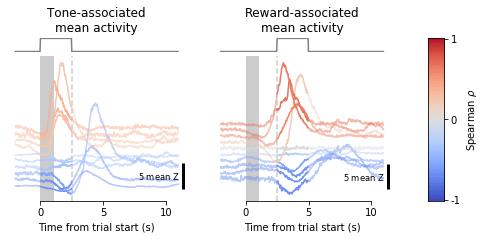

In [20]:
plt.figure(figsize=(8, 3))

spec = gs.GridSpec(
    2, 3, width_ratios=[1, 1, 0.2], height_ratios=[0.1, 1], hspace=0.05
)

for i, (trial_component, label, mask) in enumerate(
    zip(
        ['tone + delay', 'reward'], 
        ['Tone-associated\nmean activity', 'Reward-associated\nmean activity'],
        [trial_structure.tone + trial_structure.delay, trial_structure.reward]
    )
):

    # Find the inds of cells with various values of mean fluorescence
    all_cell_fluo_means = mean_fluo_df.loc[
        mean_fluo_df['day'] == cond.Day(7), 
        trial_component + ' fluo'
    ].to_numpy()
    inds_sorted_by_mean = np.argsort(all_cell_fluo_means)
    cells_to_show = np.concatenate([
        inds_sorted_by_mean[:4], 
        inds_sorted_by_mean[int(len(inds_sorted_by_mean) // 2)-1:int(len(inds_sorted_by_mean) // 2)+1],
        inds_sorted_by_mean[-4:]
    ])
    print(f'Cell types to show for {trial_component}: {mean_fluo_df.loc[mean_fluo_df["day"] == cond.Day(7), ["cell_type", trial_component]].iloc[cells_to_show, :]}')

    traces_ = average_traces[days == cond.Day(7), :][cells_to_show, :].T
    means_ = mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].iloc[cells_to_show]


    plt.subplot(spec[0, i])
    plt.title(label)
    plt.plot(
        trial_structure.time - trial_structure.baseline_duration,
        mask,
        color='gray',
    )
    plt.gca().axis('off')
    
    plt.subplot(spec[1, i])
    mark_trial_structure()
    
    for j, k in enumerate(np.argsort(means_)):
        component = traces_[:, k].copy()
        component[~mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            component + j*1.2,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[k]))
        )
        
        not_component = traces_[:, k].copy()
        not_component[mask] = np.nan
        
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            not_component + j*1.2,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[k])),
            alpha=0.5
        )
    
    pltools.add_scalebar(y_units=' mean Z', remove_frame=False, omit_x=True)
    pltools.hide_border('trl', trim=True)
    
    plt.xlabel('Time from trial start (s)')
    
ax = plt.subplot(spec[:, -1])
plt.imshow(np.linspace(1, -1, 101)[:, np.newaxis], cmap='coolwarm', aspect=0.1)
plt.yticks([0, 50, 100], [1, 0, -1])
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
plt.ylabel('Spearman $\\rho$')
plt.xticks([])

plt.tight_layout()

savefig('../img/graphics/sample_responsive_cells', dpi=600, bbox_inches='tight')

del cells_to_show, traces_, means_

Cell types to show for tone + delay:      cell_type  tone + delay
1932       pyr     -0.315843
4010        pv     -0.366408
2394       pyr      0.306828
2618       pyr      0.242798
2614       pyr      0.373400
2606       pyr      0.221243
Cell types to show for reward:      cell_type    reward
768         pv -0.024069
425        vip -0.225520
1956       pyr  0.589645
3388       pyr  0.669913
2094       pyr  0.192754
2628       pyr  0.647260
Saving png


<ipython-input-22-936fa097dc37>:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving svg
Saving eps
Saving pdf


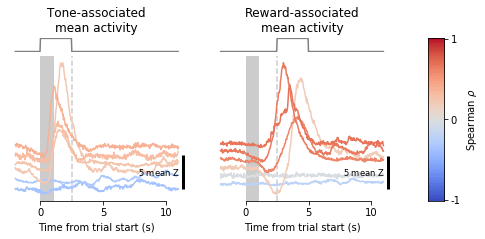

In [22]:
plt.figure(figsize=(8, 3))

spec = gs.GridSpec(
    2, 3, width_ratios=[1, 1, 0.2], height_ratios=[0.1, 1], hspace=0.05
)

for i, (trial_component, label, mask) in enumerate(
    zip(
        ['tone + delay', 'reward'], 
        ['Tone-associated\nmean activity', 'Reward-associated\nmean activity'],
        [trial_structure.tone + trial_structure.delay, trial_structure.reward]
    )
):

    # Find the inds of cells with various values of mean fluorescence
    all_cell_fluo_means = mean_fluo_df.loc[
        mean_fluo_df['day'] == cond.Day(7), 
        trial_component + ' fluo'
    ].to_numpy()
    inds_sorted_by_mean = np.argsort(all_cell_fluo_means)
    cells_to_show = np.concatenate([
        inds_sorted_by_mean[int(len(inds_sorted_by_mean) // 2)-1:int(len(inds_sorted_by_mean) // 2)+1],
        inds_sorted_by_mean[-4:]
    ])
    print(f'Cell types to show for {trial_component}: {mean_fluo_df.loc[mean_fluo_df["day"] == cond.Day(7), ["cell_type", trial_component]].iloc[cells_to_show, :]}')

    traces_ = average_traces[days == cond.Day(7), :][cells_to_show, :].T
    means_ = mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), trial_component].iloc[cells_to_show]


    plt.subplot(spec[0, i])
    plt.title(label)
    plt.plot(
        trial_structure.time - trial_structure.baseline_duration,
        mask,
        color='gray',
    )
    plt.gca().axis('off')
    
    plt.subplot(spec[1, i])
    mark_trial_structure()
    
    for j, k in enumerate(np.argsort(means_)):
        plt.plot(
            trial_structure.time - trial_structure.baseline_duration,
            traces_[:, k] + j*1.2,
            color=plt.cm.coolwarm(to_unit_interval(means_.iloc[k]))
        )

    pltools.add_scalebar(y_units=' mean Z', remove_frame=False, omit_x=True)
    pltools.hide_border('trl', trim=True)
    
    plt.xlabel('Time from trial start (s)')
    
ax = plt.subplot(spec[:, -1])
plt.imshow(np.linspace(1, -1, 101)[:, np.newaxis], cmap='coolwarm', aspect=0.1)
plt.yticks([0, 50, 100], [1, 0, -1])
plt.gca().yaxis.set_ticks_position('right')
plt.gca().yaxis.set_label_position('right')
plt.ylabel('Spearman $\\rho$')
plt.xticks([])

plt.tight_layout()

savefig('../img/graphics/sample_pos_responsive_cells', dpi=600, bbox_inches='tight')

del cells_to_show, traces_, means_

In [22]:
FRAME_RATE = 30.0
BASELINE_DURATION = 2.
time_vec = np.arange(390) / FRAME_RATE - BASELINE_DURATION

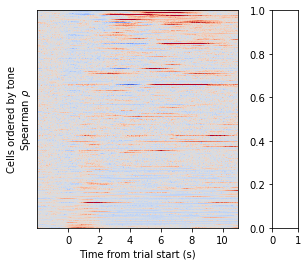

In [26]:
celltype_number = {
    cond.CellType.pyr: 0,
    cond.CellType.vip: 1,
    cond.CellType.pv: 2,
    cond.CellType.som: 3,
}

Saving png
Saving svg


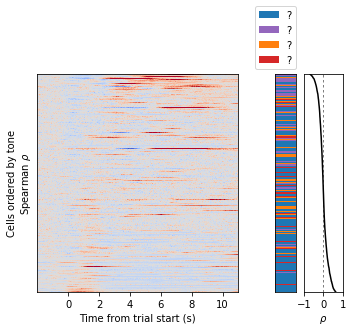

In [27]:
fluo_spec = gs.GridSpec(1, 3, width_ratios=[1, 0.1, 0.15], wspace=0.05)

plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by tone\nSpearman $\\rho$')
plt.xlabel('Time from trial start (s)')

ax = plt.subplot(fluo_spec[:, 1])
ct_barcode = ax.imshow(
    np.array([celltype_number[ct] 
              for ct in 
              cell_types[days==7][np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'])]]
            )[:, np.newaxis], 
    aspect=0.005,
    cmap=ListedColormap([sns.color_palette()[i] for i in [0, 4, 1, 3]])
)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(handles=[
    Patch(facecolor=sns.color_palette()[0], label='?'),  # PN? 
    Patch(facecolor=sns.color_palette()[4], label='?'),  # VIP?
    Patch(facecolor=sns.color_palette()[1], label='?'),  # PV?
    Patch(facecolor=sns.color_palette()[3], label='?'),  # SOM?
], loc='lower center', bbox_to_anchor=(0, 1))

plt.subplot(fluo_spec[:, 2])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('$\\rho$')

savefig('../img/graphics/fluo_ordered_by_tone', dpi=600, bbox_inches='tight')
plt.show()

In [28]:
stats.ks_2samp(
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'tone + delay'].to_numpy().flatten(),
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'tone + delay'].to_numpy().flatten()
)

Ks_2sampResult(statistic=0.061660974567836625, pvalue=0.0006215814917600593)

Saving png
Saving svg


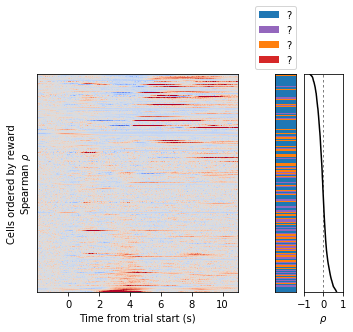

In [29]:
plt.subplot(fluo_spec[:, 0])
plt.imshow(
    average_traces[
        days == cond.Day(7), 
        :
    ][
        np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
        :
    ],
    cmap='coolwarm',
    vmin=-2,
    vmax=2,
    aspect=0.2
)
plt.xticks((np.arange(0, 11, 2) + BASELINE_DURATION) * FRAME_RATE, np.arange(0, 11, 2))
plt.yticks([])
plt.ylabel('Cells ordered by reward\nSpearman $\\rho$')
plt.xlabel('Time from trial start (s)')

ax = plt.subplot(fluo_spec[:, 1])
ct_barcode = ax.imshow(
    np.array([celltype_number[ct] 
              for ct in 
              cell_types[days==7][np.argsort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward'])]]
            )[:, np.newaxis], 
    aspect=0.005,
    cmap=ListedColormap([sns.color_palette()[i] for i in [0, 4, 1]])
)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(handles=[
    Patch(facecolor=sns.color_palette()[0], label='?'),  # PN? 
    Patch(facecolor=sns.color_palette()[4], label='?'),  # VIP?
    Patch(facecolor=sns.color_palette()[1], label='?'),  # PV?
    Patch(facecolor=sns.color_palette()[3], label='?'),  # SOM?
], loc='lower center', bbox_to_anchor=(0, 1))

plt.subplot(fluo_spec[:, 2])
plt.axvline(0, color='k', ls='--', lw=0.5, dashes=(5, 5))
plt.plot(
    np.sort(mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward']),
    np.linspace(1, 0, sum(mean_fluo_df['day'] == cond.Day(7))),
    'k-'
)
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.yticks([])
plt.xlabel('$\\rho$')

savefig('../img/graphics/fluo_ordered_by_reward', dpi=600, bbox_inches='tight')

plt.show()

In [30]:
stats.ks_2samp(
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(1), 'reward'].to_numpy().flatten(),
    mean_fluo_df.loc[mean_fluo_df['day'] == cond.Day(7), 'reward'].to_numpy().flatten()
)

Ks_2sampResult(statistic=0.12597565257844248, pvalue=4.076350146320351e-09)